In [21]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA

# 0. Preprocessing and Reading Data

In [100]:
patient = 1
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")

# Remove Empty Rows
zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmSeries = cgmSeries[zero_entries == False]
insulinBasal = insulinBasal[zero_entries == False]
insulinBolus = insulinBolus[zero_entries == False]
insulinTime = insulinTime[zero_entries == False]

In [101]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

# 1.a Anirudh Features

In [102]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append(slope)
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [103]:
# Regression Error
reg_window_size = 6
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

11.52000006866455
0.08680555503815413


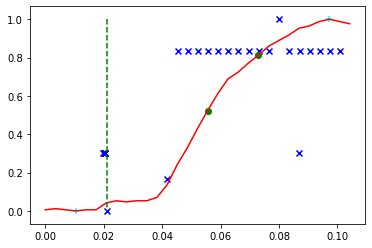

[0.81176471 0.52352941]
[0.03529412 0.09882353]
[0.07291667 0.05555555]


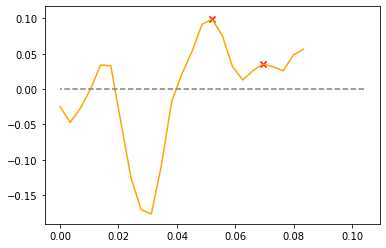

20.571428615219737
0.048611111007630825


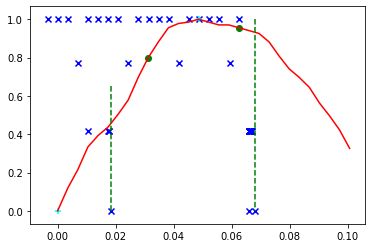

[0.95555556 0.8       ]
[0.09629631 0.15703703]
[0.0625  0.03125]


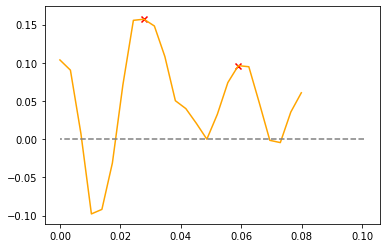

13.714285677793074
0.0729166668606922


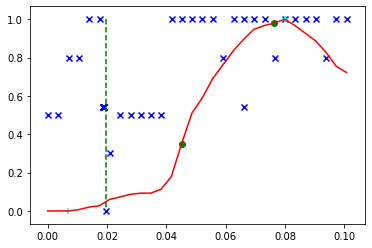

[0.98013245 0.35099338]
[0.1245033  0.16953644]
[0.07638889 0.04513889]


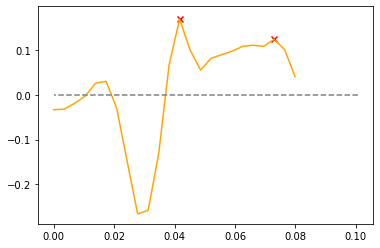

13.090909053225163
0.0763888891087845


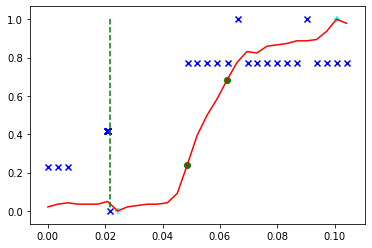

[0.23943662 0.68309859]
[0.11830988 0.16197184]
[0.04861111 0.0625    ]


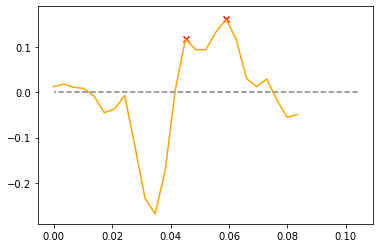

32.0
0.03125


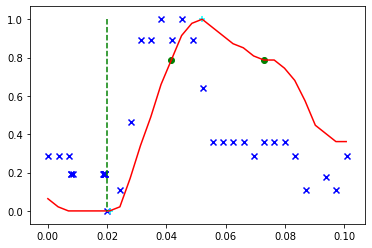

[0.78723404 0.78723404]
[0.17872342 0.30212766]
[0.07291667 0.04166667]


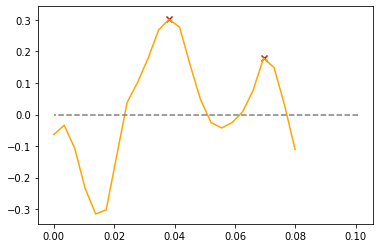

15.15789457041141
0.06597222294658422


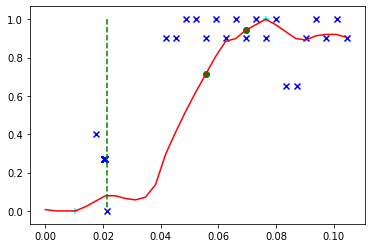

[0.71223022 0.94244604]
[0.12661871 0.13956834]
[0.05555555 0.06944444]


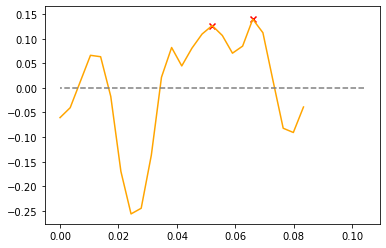

32.0
0.03125


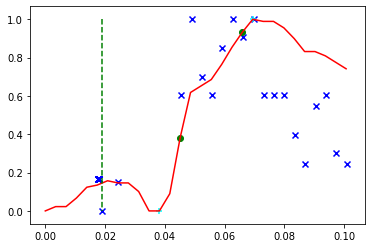

[0.93258427 0.38202247]
[0.20674158 0.39101125]
[0.0659838  0.04515046]


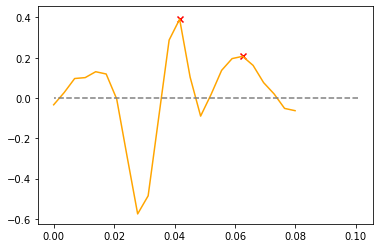

13.714285634001907
0.07291666709352285


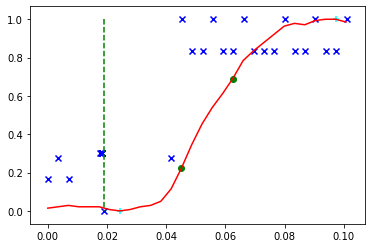

[0.22302158 0.69064748]
[0.07338132 0.08633094]
[0.04513889 0.0625    ]


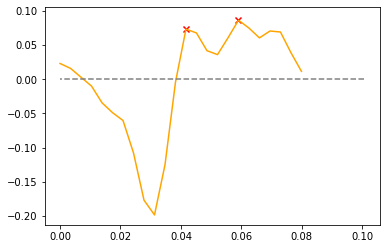

10.666666666666666
0.09375


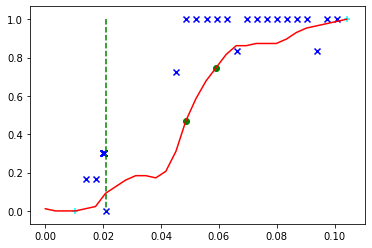

[0.74712644 0.47126437]
[0.12873563 0.15172416]
[0.05902778 0.04861111]


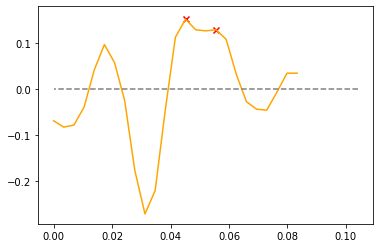

19.187208368406285
0.05211805598810315


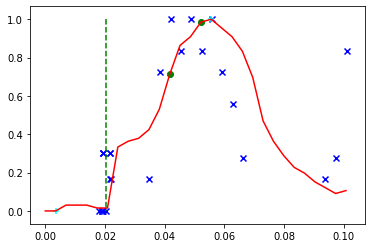

[0.98484848 0.71212121]
[0.26060606 0.30293396]
[0.05211806 0.04166667]


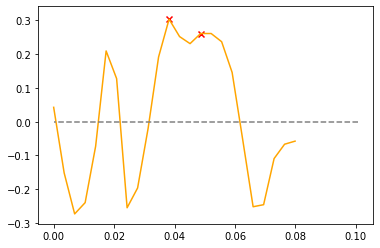

16.941176411189836
0.05902777798473835


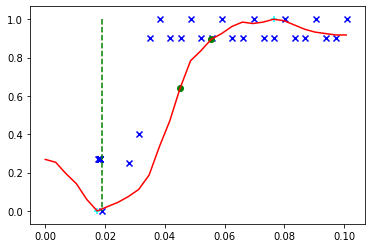

[0.89552239 0.64179104]
[0.07761194 0.23134328]
[0.05555556 0.04513889]


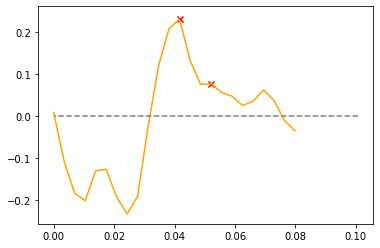

16.0
0.0625


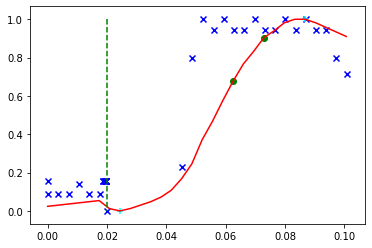

[0.67664671 0.90419162]
[0.09461077 0.10778443]
[0.0625     0.07291667]


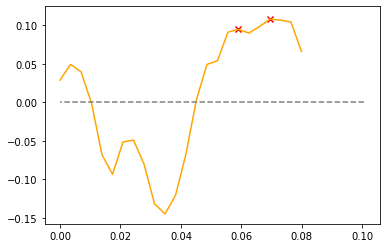

16.0
0.0625


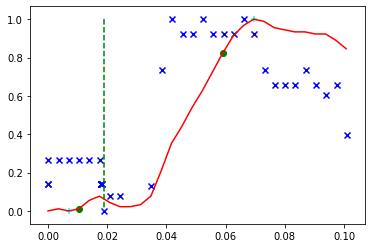

[0.01098901 0.82417582]
[0.09230769 0.19560439]
[0.01042824 0.05903935]


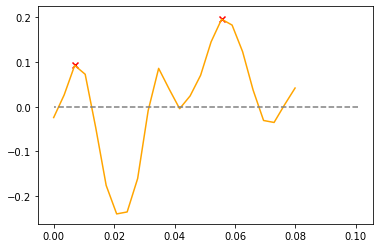

18.003750966506455
0.05554398091044277


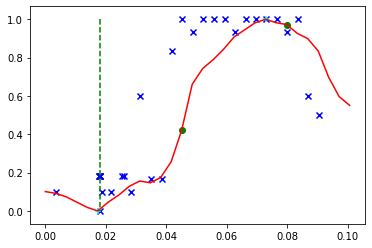

[0.97247706 0.42201835]
[0.15412842 0.29357798]
[0.07984954 0.04512731]


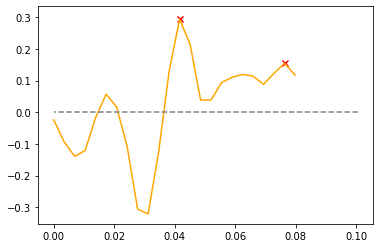

10.66666666666667
0.09375


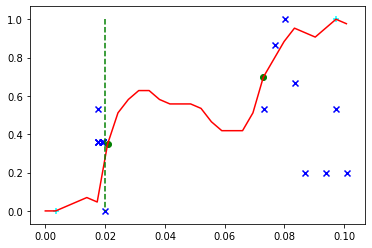

[0.69767442 0.34883721]
[0.26976745 0.46511627]
[0.07291667 0.02083333]


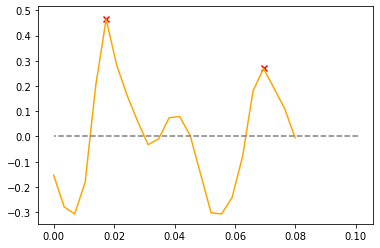

14.400000061690807
0.06944444414693862


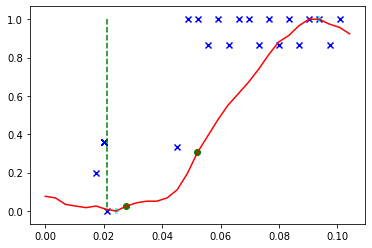

[0.02542373 0.30508475]
[0.00338983 0.06610168]
[0.02777778 0.05208333]


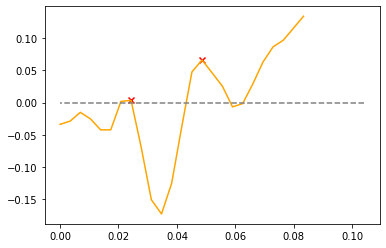

26.18181838575474
0.03819444414693862


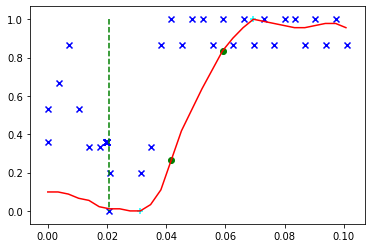

[0.26373626 0.83516484]
[0.10329669 0.15384615]
[0.04166667 0.05902778]


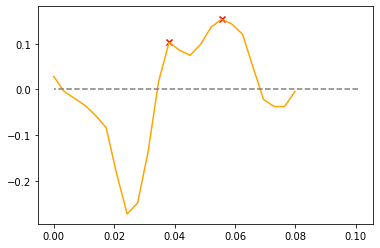

10.000000204890977
0.020833332906477153


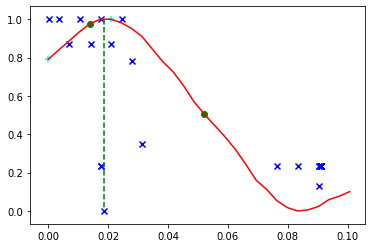

[0.50595238 0.97619048]
[0.02619046 0.125     ]
[0.05208333 0.01388889]


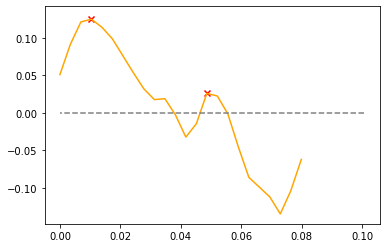

12.521738982380906
0.07986111205536872


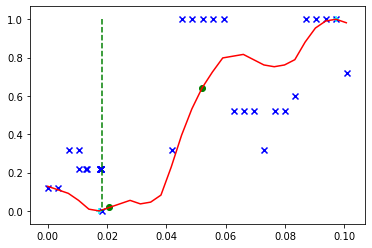

[0.01834862 0.64220183]
[0.01834862 0.19633028]
[0.02083333 0.05208333]


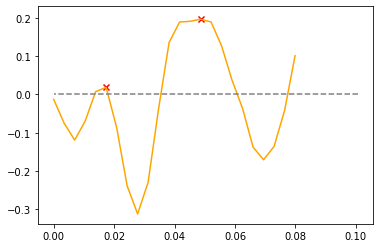

13.714285655897495
0.07291666697710752


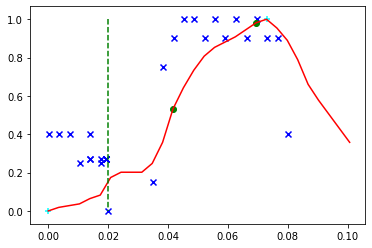

[0.53211009 0.98165138]
[0.18715598 0.25137616]
[0.04166667 0.06944444]


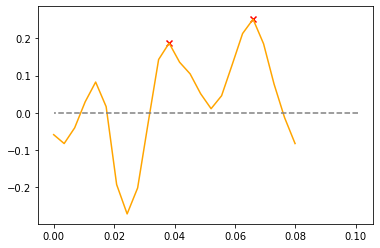

15.155235985476072
0.06598379602655768


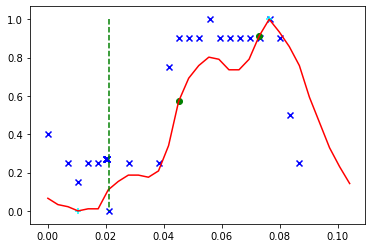

[0.57142857 0.91208791]
[0.36702349 0.43296705]
[0.04513889 0.07292824]


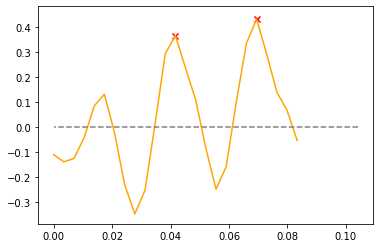

0.0
0.0


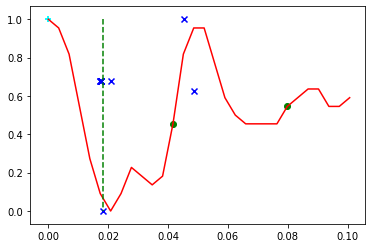

[0.54545455 0.45454545]
[0.20909091 0.89090911]
[0.07988426 0.04166667]


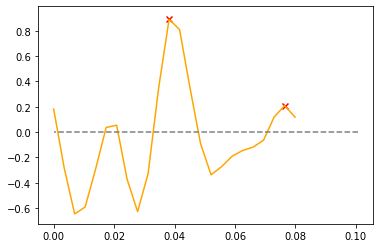

18.00000016763807
0.055555555038154125


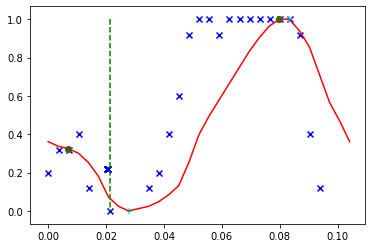

[0.3253012 1.       ]
[0.12289157 0.28915663]
[0.00694444 0.07986111]


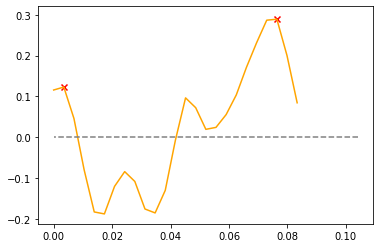

18.000000167638063
0.055555555038154125


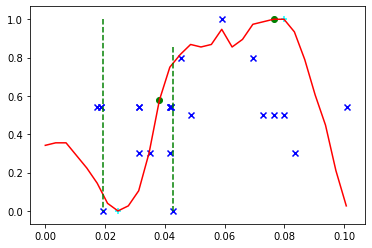

[1.         0.57894737]
[0.34210523 0.41842105]
[0.07638889 0.03819444]


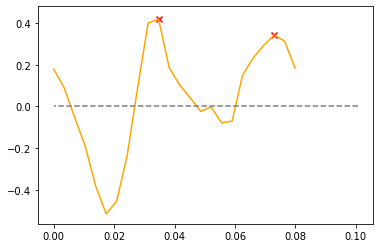

16.000000000000004
0.0625


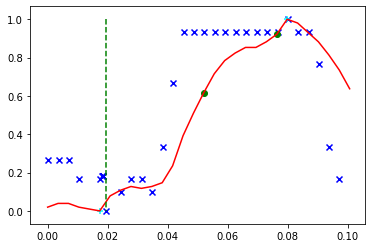

[0.61764706 0.92156863]
[0.15882354 0.22745099]
[0.05208333 0.07638889]


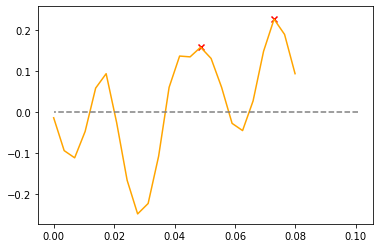

20.571428565954673
0.04861111112404615


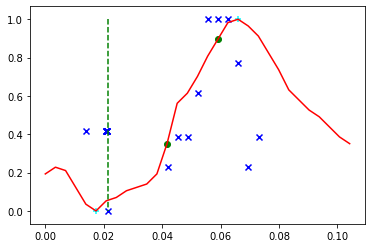

[0.35087719 0.89473684]
[0.17894736 0.29122808]
[0.04166667 0.05902778]


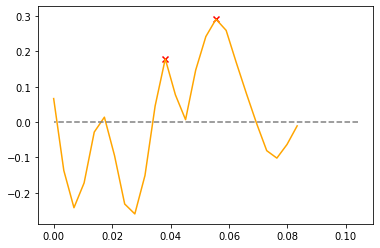

0.0
0.0


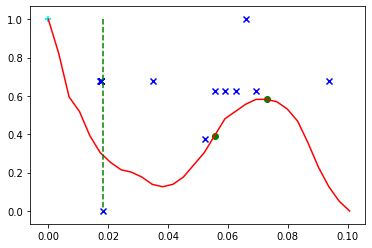

[0.39240506 0.58227848]
[0.13417721 0.19240507]
[0.05555556 0.07291667]


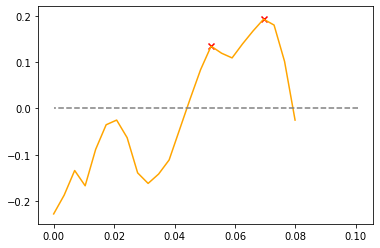

0.0
0.0


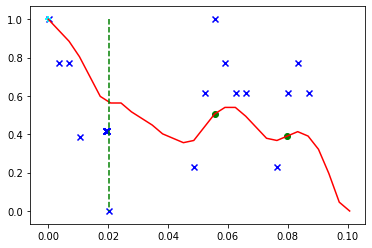

[0.50574713 0.3908046 ]
[0.21149425 0.27816095]
[0.05555556 0.07986111]


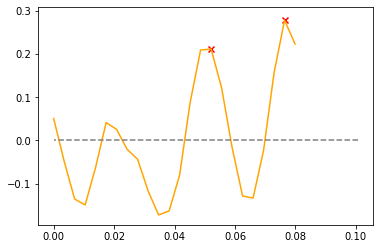

11.999999910593033
0.08333333395421505


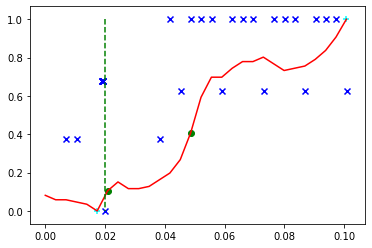

[0.10465116 0.40697674]
[0.12093023 0.26744185]
[0.02083333 0.04861111]


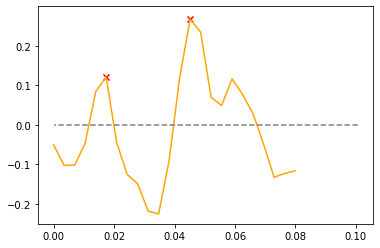

0.0
0.0


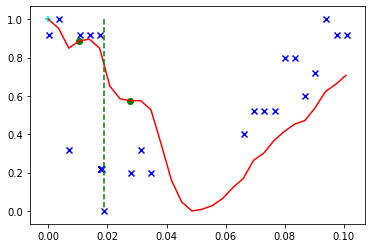

[0.88679245 0.5754717 ]
[0.22452829 0.31698112]
[0.01041667 0.02777778]


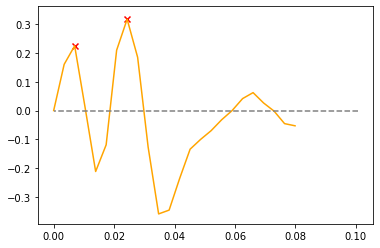

32.76190561623802
0.024305554921738803


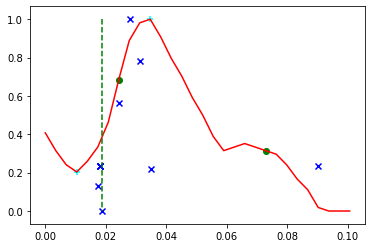

[0.31481481 0.68518519]
[0.10740741 0.55555557]
[0.07291667 0.02430556]


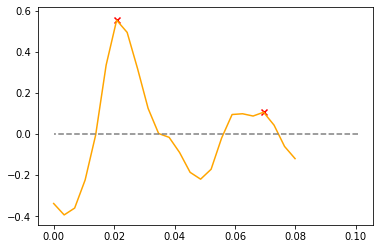

16.93453572002204
0.05905092507600784


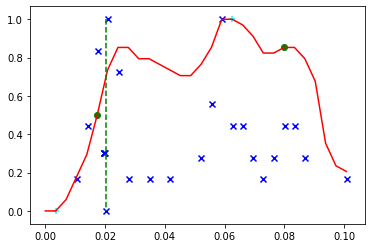

[0.85294118 0.5       ]
[0.42941178 0.4882353 ]
[0.07988426 0.01736111]


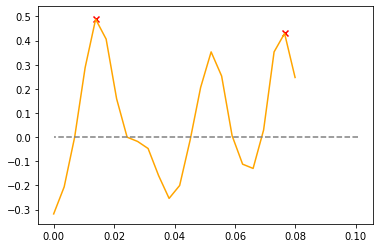

15.999999999999998
0.0625


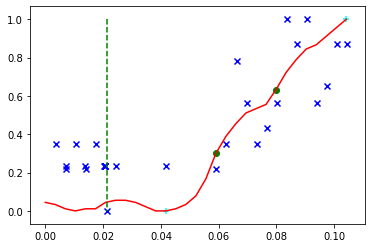

[0.63333333 0.3       ]
[0.08888888 0.15777778]
[0.07986111 0.05902778]


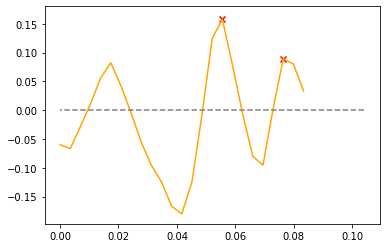

In [104]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()    

# 1.b Vedant Features

In [105]:
# Windowed features
window_mins = []
window_maxs = []
window_means = []
window_vars = []
for i in range(0, len(cgmSeries_np)):
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features = dataframe.nlargest(2,'var')
    window_values = window_features.values
    window_mins.append([window_values[0][1], window_values[1][1]])
    window_maxs.append([window_values[0][3], window_values[1][3]])
    window_vars.append([window_values[0][0], window_values[1][0]])
    window_means.append([window_values[0][2], window_values[1][2]])

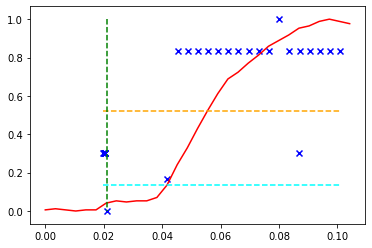

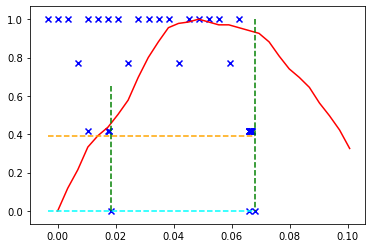

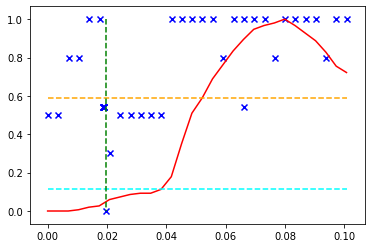

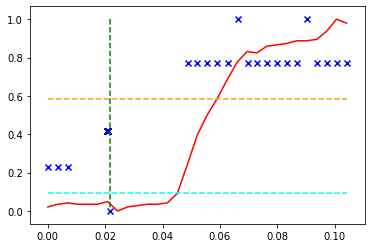

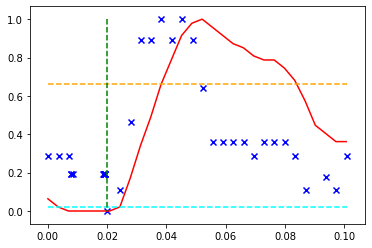

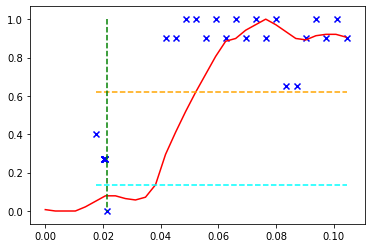

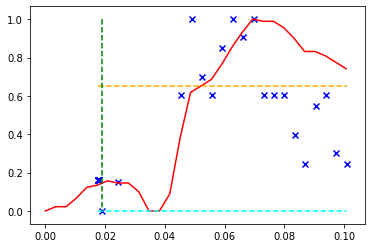

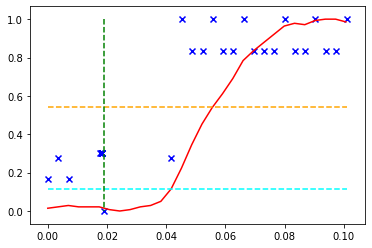

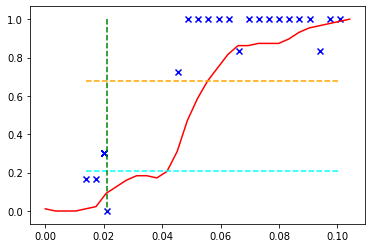

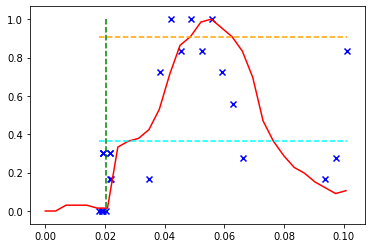

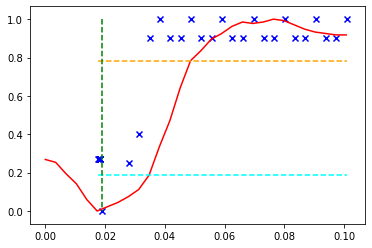

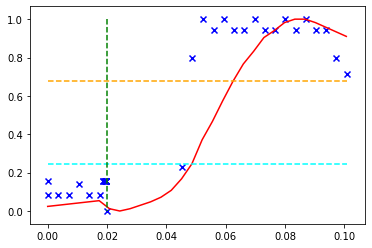

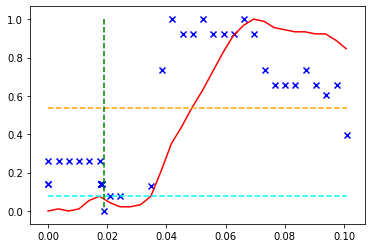

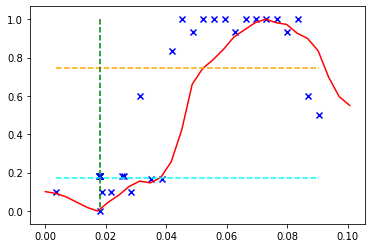

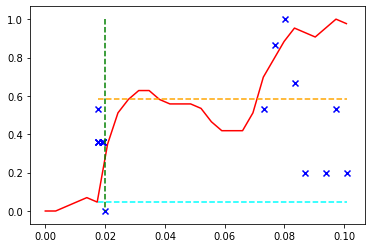

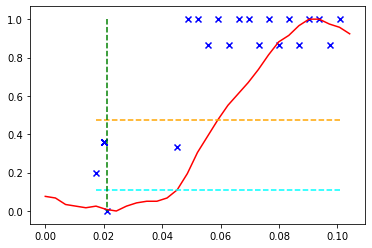

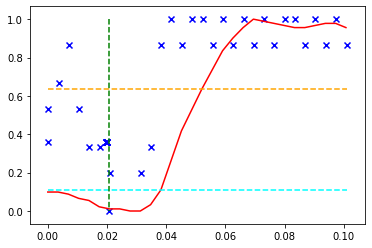

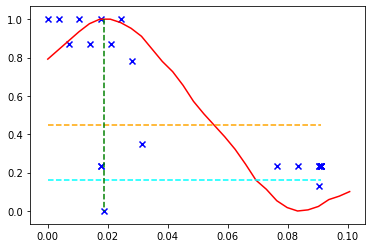

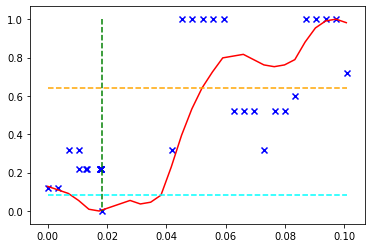

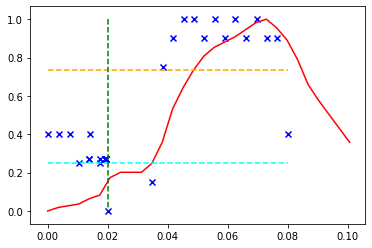

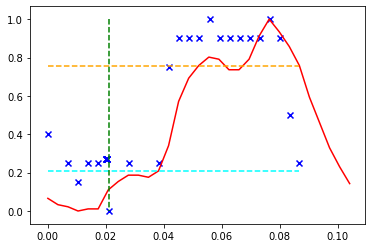

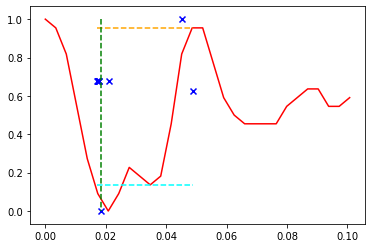

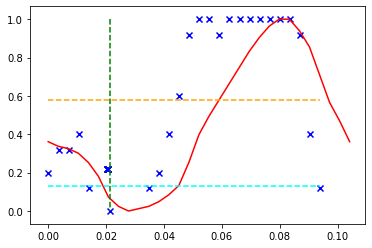

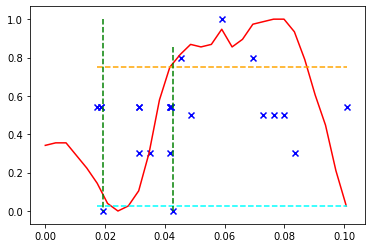

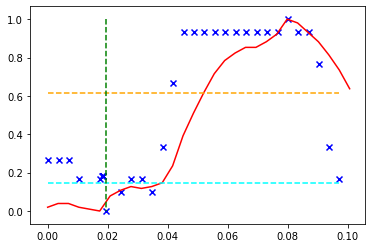

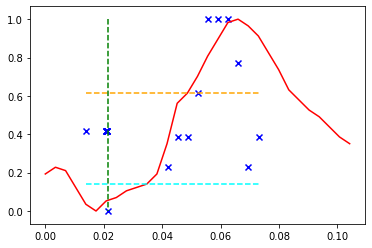

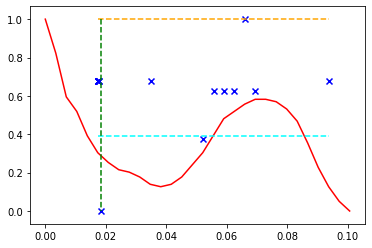

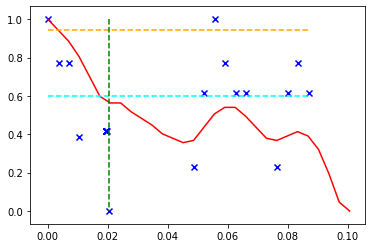

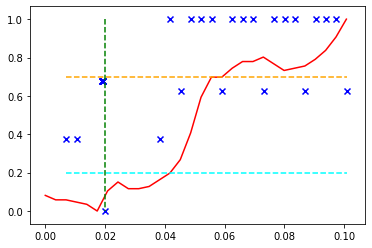

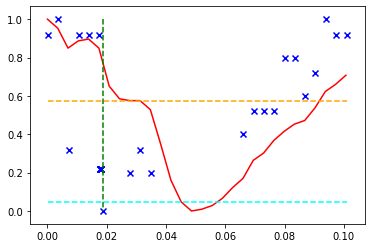

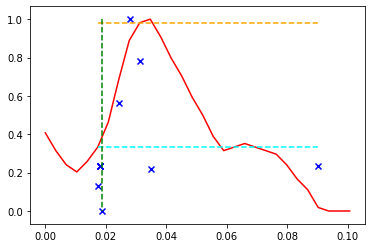

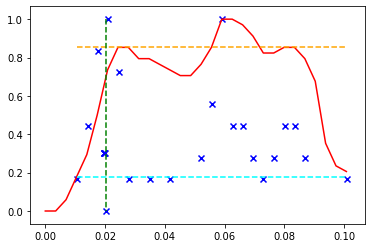

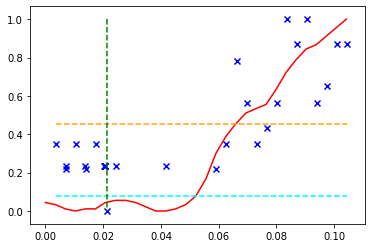

In [106]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    po1 = np.nanmin(insulinTime_np[i])
    po2 = np.nanmax(insulinTime_np[i])
    plt.plot([po1, po2], [window_mins[i][0], window_mins[i][0]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][0], window_maxs[i][0]], c='orange', linestyle='dashed')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()

# 1.c Omkar Features

In [107]:
# series = cgmNorm_np
# datenum = cgmSeries_np
# InsulinBolus = insulinBolusNorm_np
# InsulinTimestamp = insulinTime_np

In [108]:
maximum=[]
for i in range(insulinBolusNorm_np[:,0].size):
    maximum.append(np.nanargmax(insulinBolusNorm_np[i]))

In [109]:
def slope(time,values):
    slope = []
    for i in range(len(values)-1):
        slope.append((values[i+1]-values[i])/(time[i+1]-time[i])) 
    slope.append(np.nan)
    slope = np.asarray(slope)
    
    return slope

0.5416666666666666


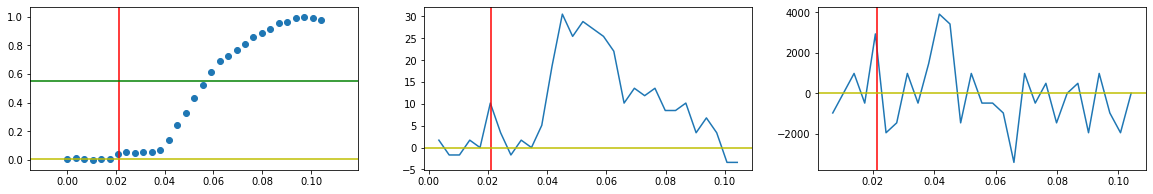

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


nan


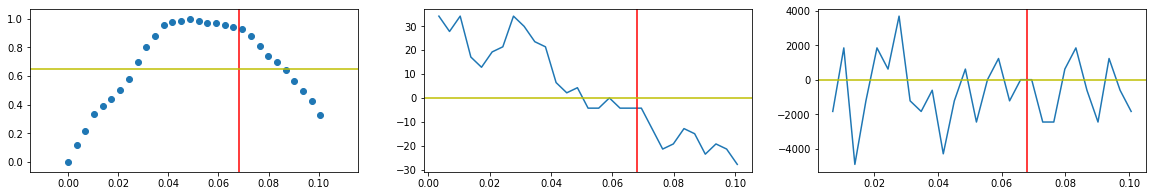

0.6940765268579838


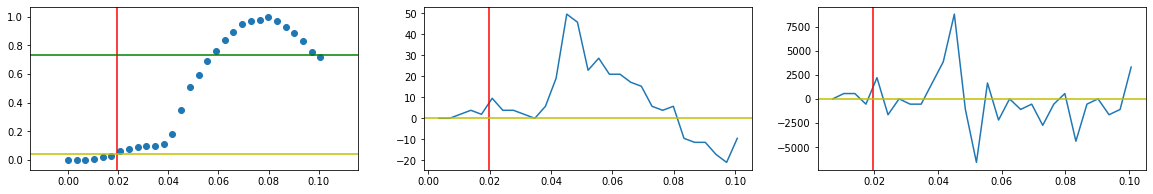

0.5816901408450704


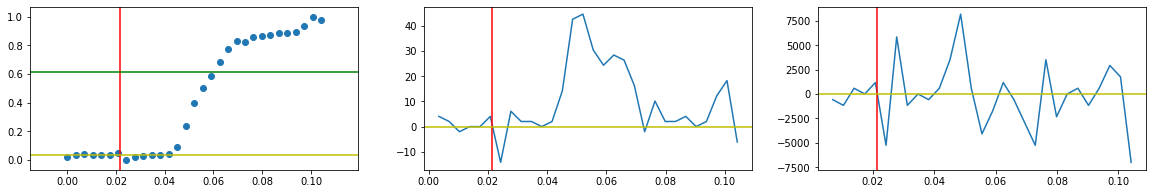

0.6164436314624049


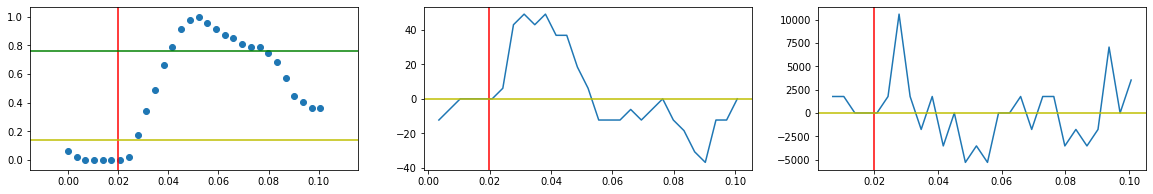

0.6261227043210151


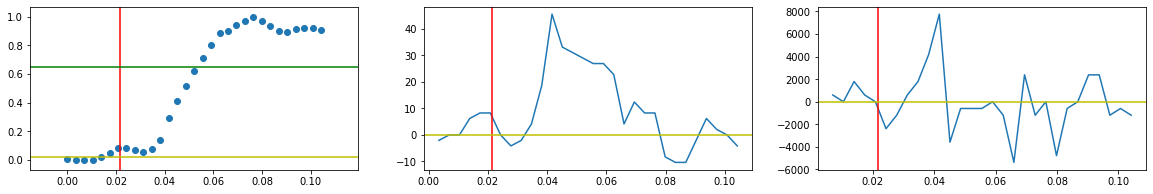

0.5585874799357945


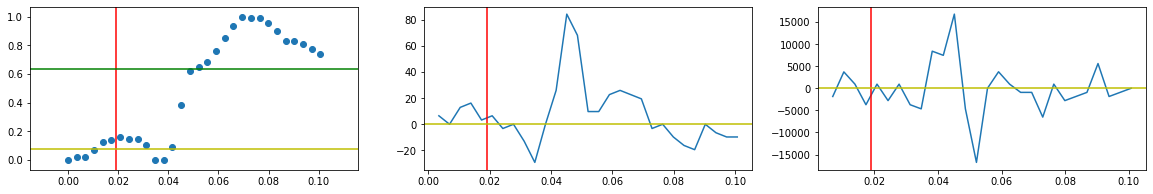

0.5741692360397397


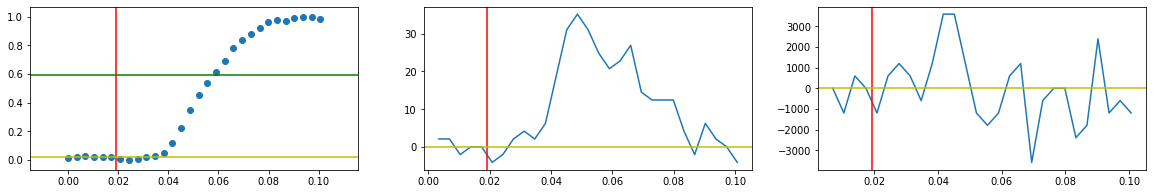

0.6294409613375131


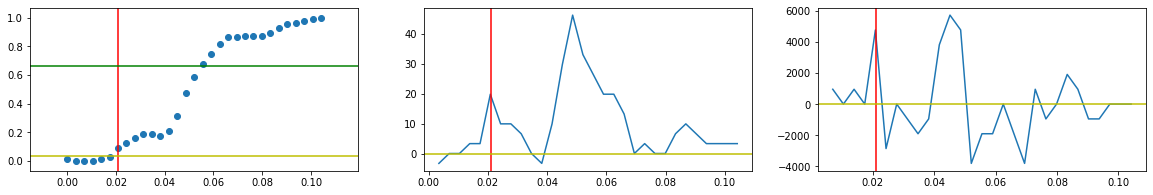

0.47790404040404044


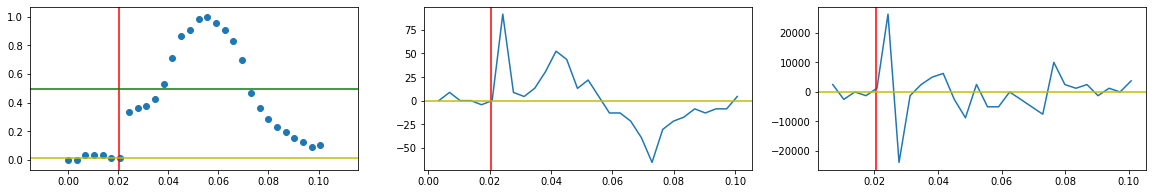

0.5228979326967648


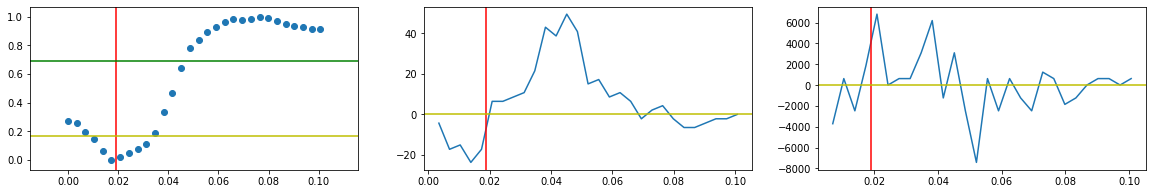

0.7540098374679214


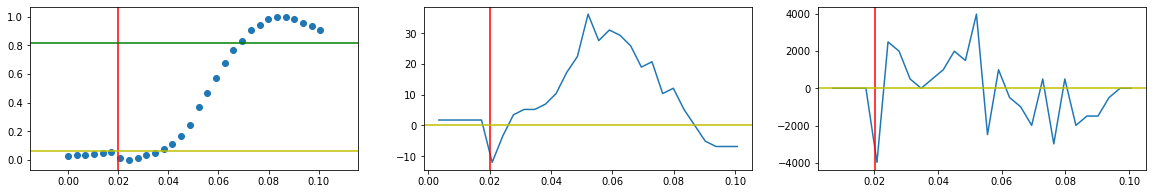

0.7803178963893251


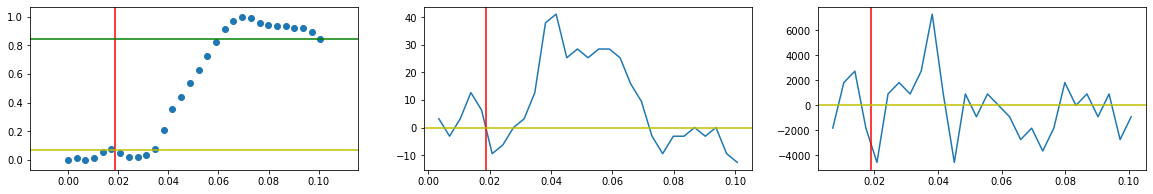

0.5194954128440368


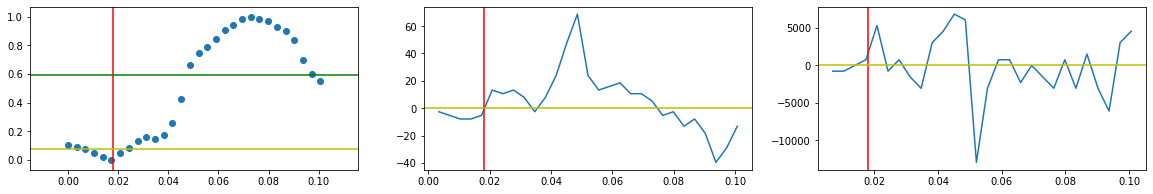

0.5069767441860464


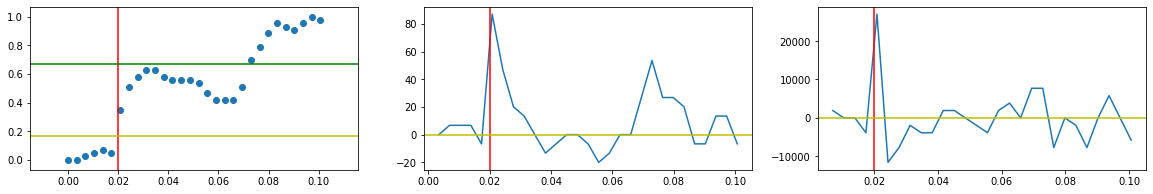

0.47620802189704176


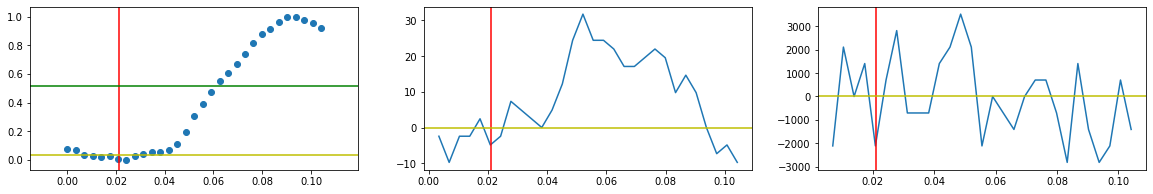

0.7728606235393566


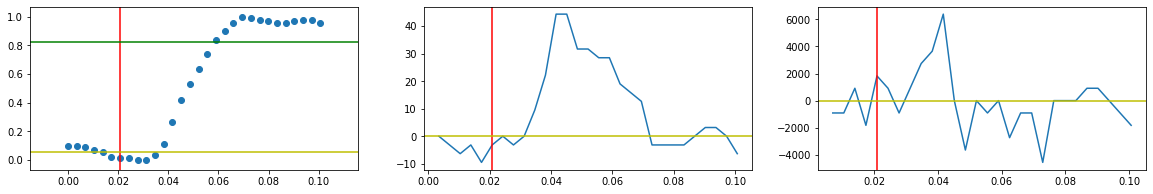

-0.46081041112097004


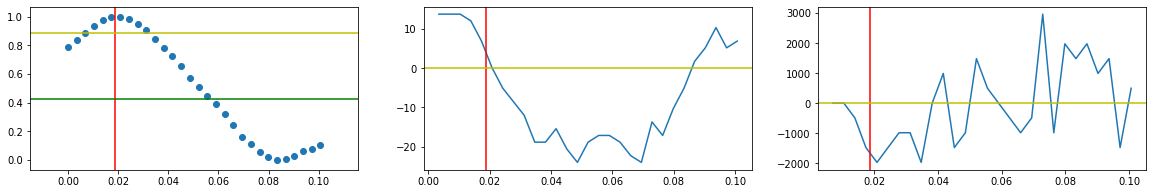

0.6811822823695463


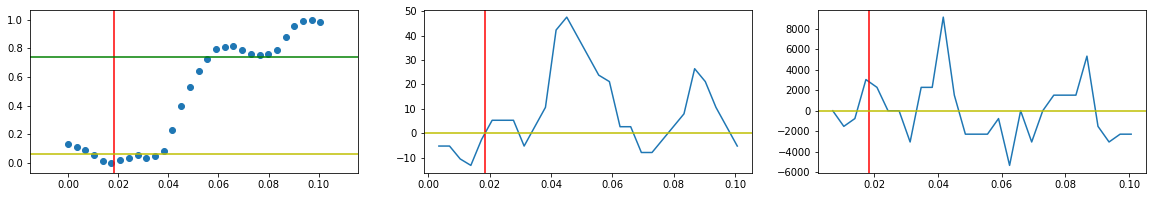

0.6085626911314985


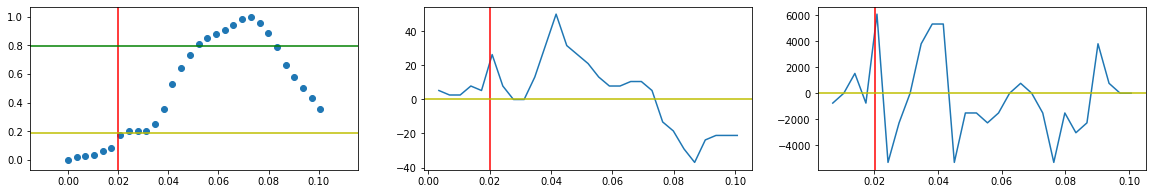

0.5712708344287291


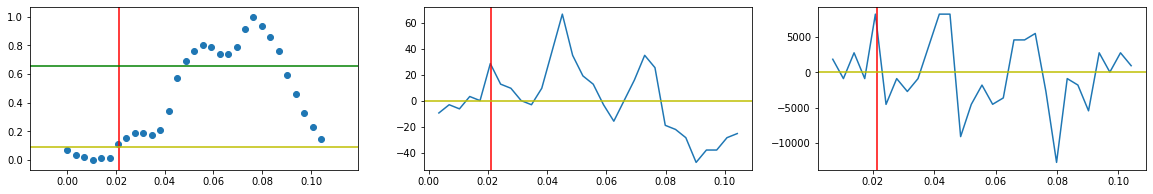

-0.2954545454545456


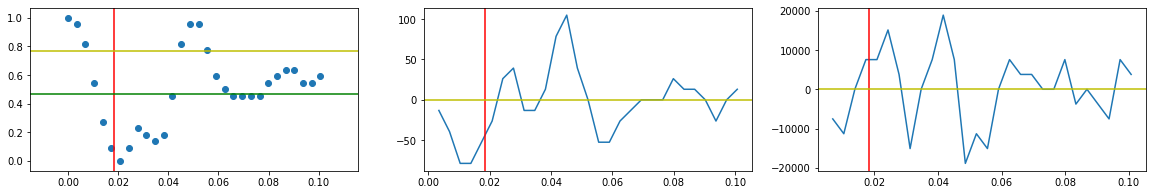

0.44059491554735697


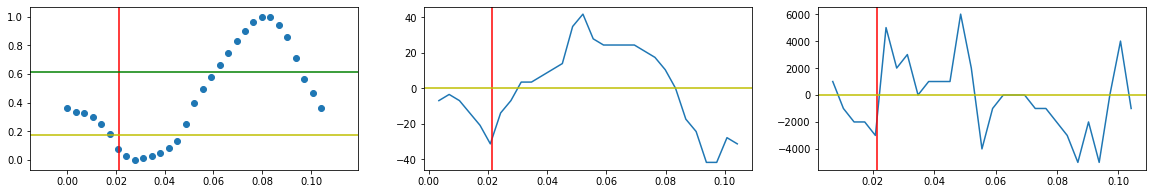

0.23731203007518775


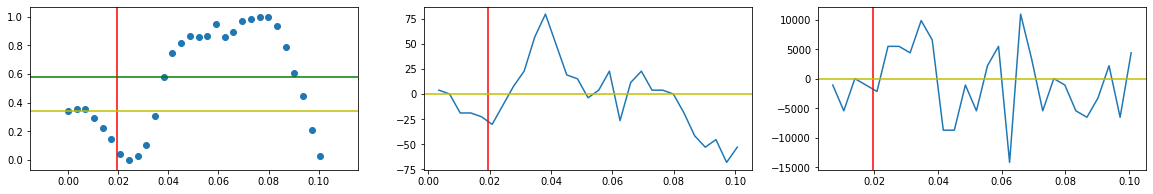

0.6424617693967538


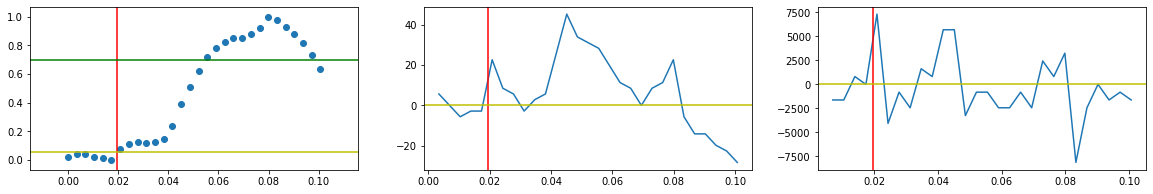

0.44644219243761574


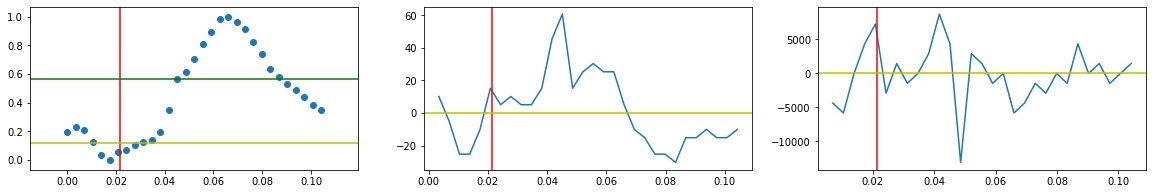

-0.399789029535865


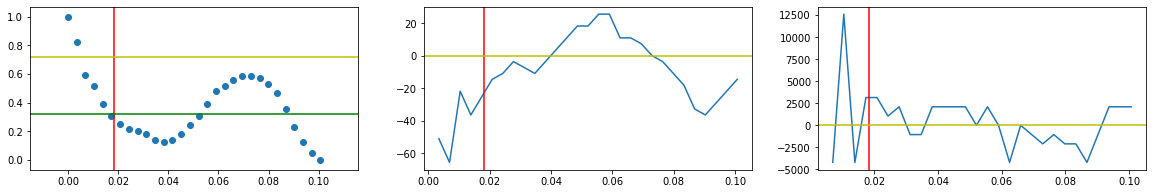

-0.342297750646208


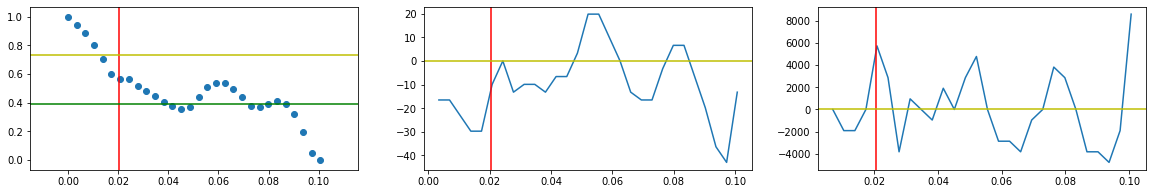

0.4952431289640591


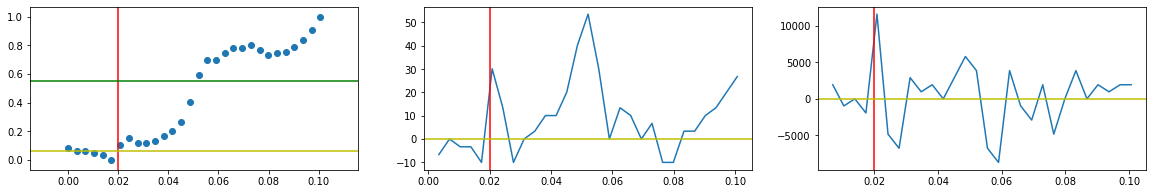

-0.4696491078289082


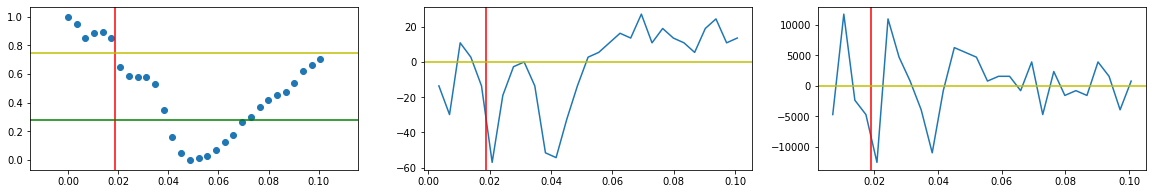

0.08760683760683763


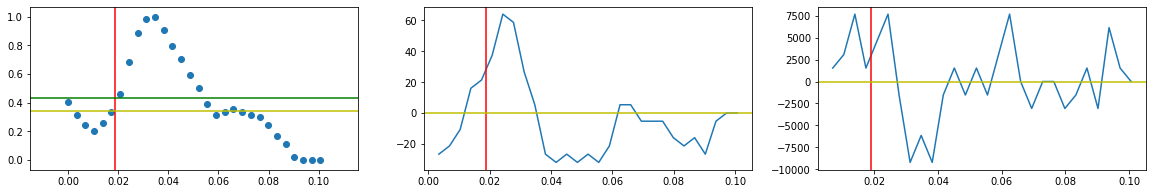

0.676470588235294


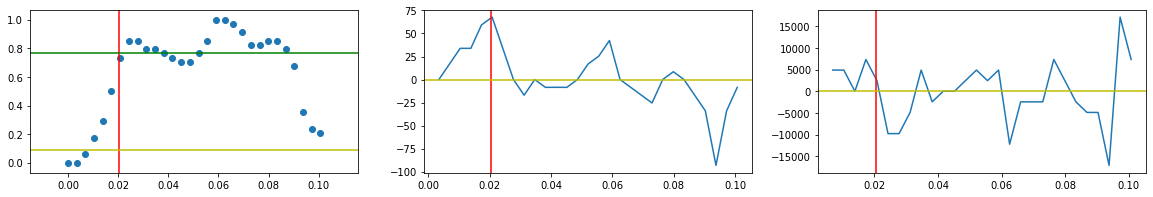

0.48939165409753643


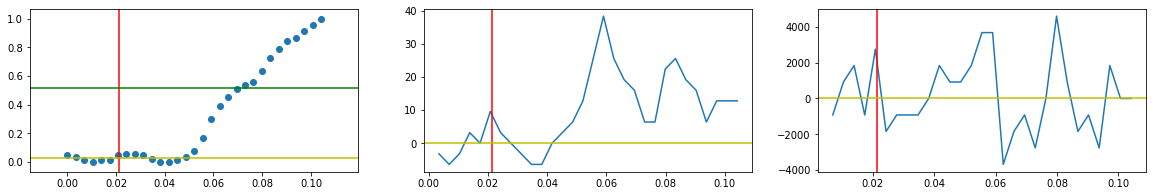

[0.5416666666666666, nan, 0.6940765268579838, 0.5816901408450704, 0.6164436314624049, 0.6261227043210151, 0.5585874799357945, 0.5741692360397397, 0.6294409613375131, 0.47790404040404044, 0.5228979326967648, 0.7540098374679214, 0.7803178963893251, 0.5194954128440368, 0.5069767441860464, 0.47620802189704176, 0.7728606235393566, -0.46081041112097004, 0.6811822823695463, 0.6085626911314985, 0.5712708344287291, -0.2954545454545456, 0.44059491554735697, 0.23731203007518775, 0.6424617693967538, 0.44644219243761574, -0.399789029535865, -0.342297750646208, 0.4952431289640591, -0.4696491078289082, 0.08760683760683763, 0.676470588235294, 0.48939165409753643]


In [113]:
mean_before = []
mean_after = []
mean_dif = []
for i in range(0,len(cgmNorm_np)):
    fig = plt.figure(figsize=(20,3))
    
    sl = slope(cgmSeries_np[i],cgmNorm_np[i])
    
    
    sl_1 = slope(cgmSeries_np[i],sl)
    sl_2 = slope(cgmSeries_np[i],sl_1)
    sl_3 = slope(cgmSeries_np[i],sl_2)
    cut = insulinTime_np[i,maximum[i]]
    cut1 = np.where(insulinTime_np[i]== cut)
    mean1 = np.nanmean(cgmNorm_np[i][-1:-int(cut1[0]):-1])
    mean2 = np.nanmean(cgmNorm_np[i][-int(cut1[0]):0:-1])
    
    mean_before.append(mean1)
    mean_after.append(mean2)
    
    print(mean2-mean1)
    
    plt.subplot(1,3,1)
    plt.scatter(cgmSeries_np[i],cgmNorm_np[i])
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = mean1,c='y')
    plt.axhline(y = mean2,c='g')
    
    plt.subplot(1,3,2)
    plt.plot(cgmSeries_np[i],sl)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    
    plt.subplot(1,3,3)
    plt.plot(cgmSeries_np[i],sl_1)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    plt.show()

mean_dif = [x - y for x, y in zip(mean_after, mean_before)]
print(mean_dif)

# 1.d Ananth Features

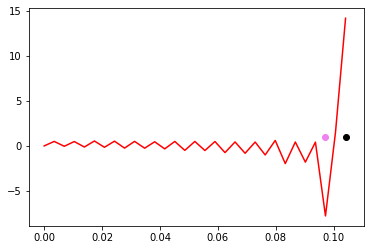

[14.152941176470591, -7.79180485872869, 0.1829278452159737, 8.896929188242058]


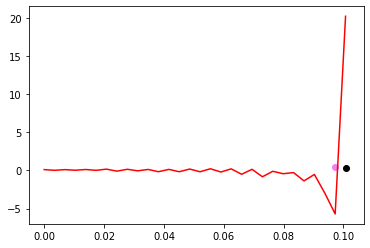

[20.2, -5.705957551777416, 0.2628243748125339, 14.552350844796294]


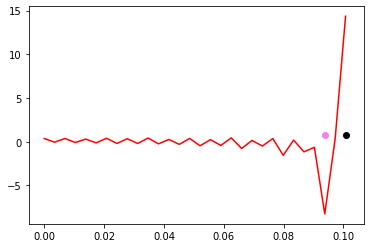

[14.357615894039736, -8.252658531102163, 0.1310711632757856, 9.062951244246785]


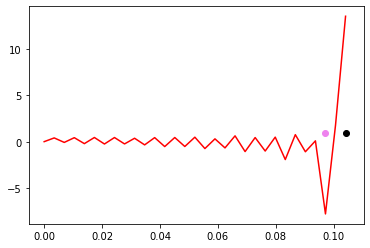

[13.521126760563382, -7.737259637951441, 0.1929759859978857, 8.274060830032717]


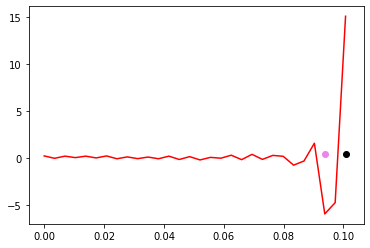

[15.063829787234036, -5.980068671572691, 0.1861416483262577, 9.299395300251561]


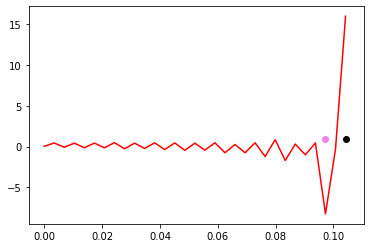

[15.985611510791369, -8.253866169424075, 0.20302508965366958, 10.734341752012881]


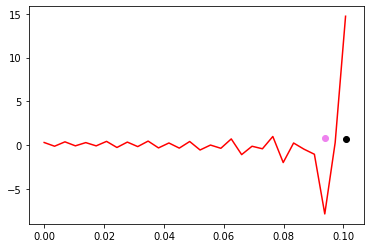

[14.719101123595504, -7.833855632170877, 0.1589898491539232, 9.265724911626203]


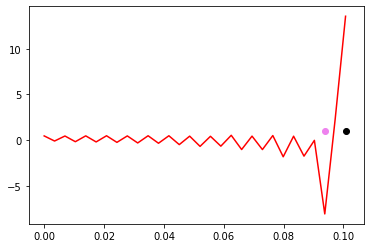

[13.546762589928058, -8.04421424055926, 0.1735090552018789, 8.556563634110683]


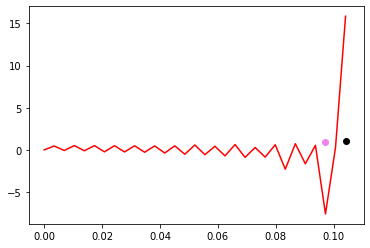

[15.839080459770118, -7.581522380154777, 0.23032631324794225, 10.372258455077953]


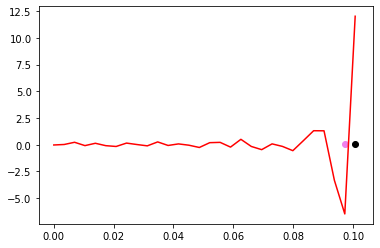

[12.030303030303031, -6.473668542026381, 0.1576539300092298, 6.510343259621045]


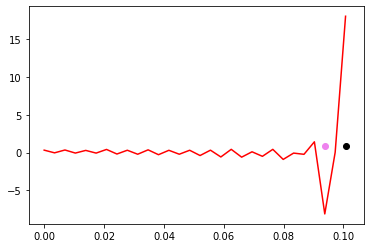

[18.029850746268657, -8.12147926407745, 0.34633296697722915, 12.673942121347247]


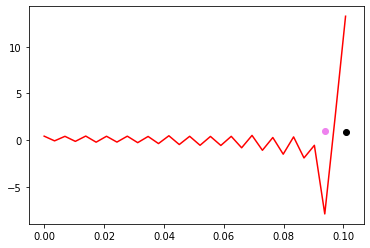

[13.251497005988021, -7.866720978916915, 0.15912330501647123, 8.203276087065548]


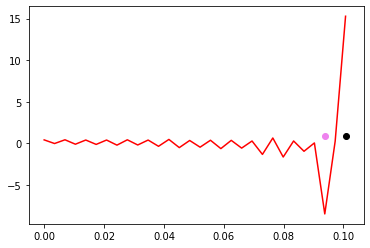

[15.285714285714286, -8.492242566966594, 0.16367735210623455, 10.130226759127467]


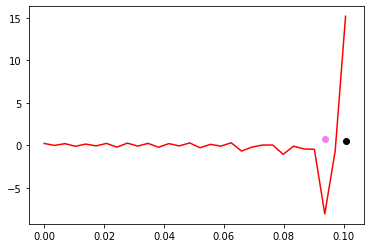

[15.174311926605505, -8.043779440527064, 0.15769413761479248, 9.591701165384217]


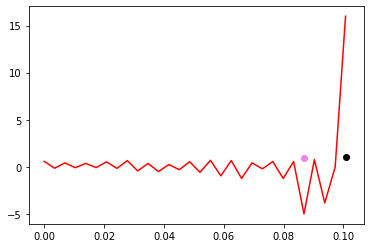

[16.0, -5.02394001566111, 0.25881366388760724, 9.779732980711891]


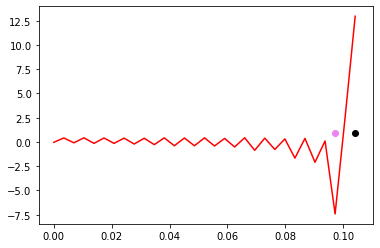

[12.966101694915253, -7.420973533258622, 0.17356033580106633, 7.75308936462714]


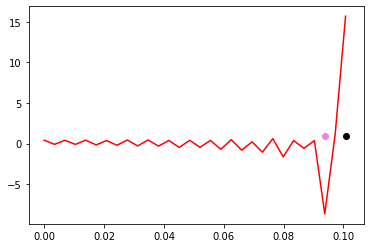

[15.692307692307695, -8.659112889596326, 0.2307339441431879, 10.624707085050446]


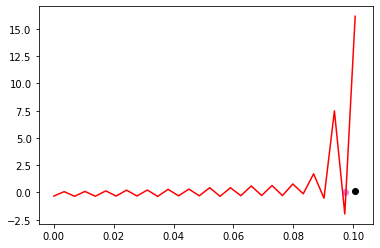

[16.160714285714285, -1.969178368142871, 0.7446833277324251, 10.011285240775608]


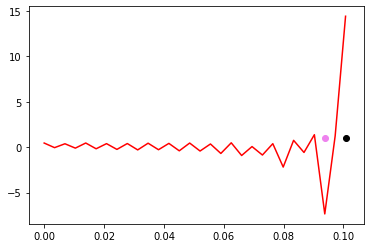

[14.403669724770642, -7.34419384540439, 0.2521718838162667, 8.811794545364311]


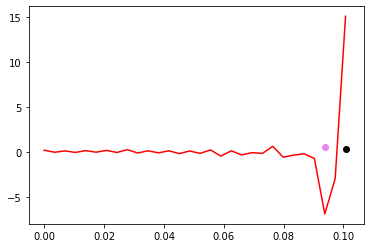

[15.064220183486242, -6.888313780972571, 0.11558314187666195, 9.191969729219679]


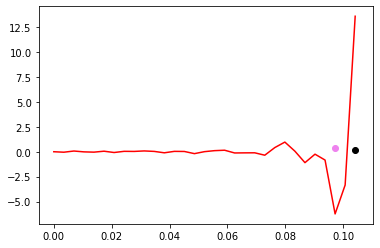

[13.60439560439561, -6.244686168346047, 0.08797222240392898, 7.689527464118289]


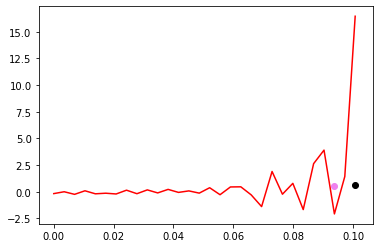

[16.454545454545446, -2.077440717102524, 0.7026666272495861, 9.486864782903822]


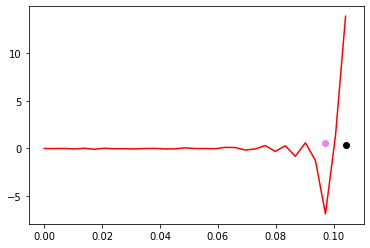

[13.891566265060245, -6.885453526229257, 0.21745697103816078, 7.86410463371923]


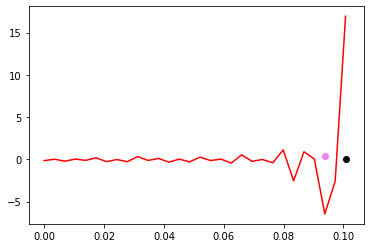

[16.934210526315788, -6.451889345144363, 0.1946257165006794, 11.091471424704098]


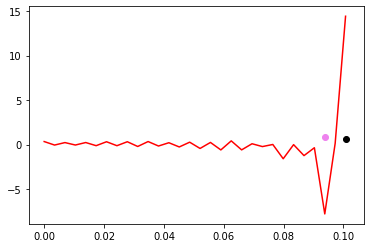

[14.421568627450984, -7.804309871308283, 0.11225137531167996, 8.864481644342577]


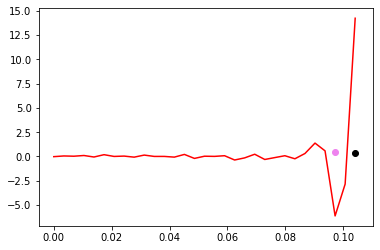

[14.228070175438594, -6.135902229765284, 0.21861939292538562, 8.051590979875483]


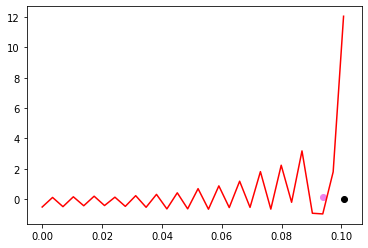

[12.050632911392409, -0.9804584462324256, 0.533028729738856, 5.373756747509949]


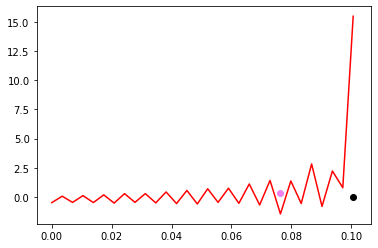

[15.471264367816094, -1.44650488592687, 0.6487974518057343, 8.158164232292261]


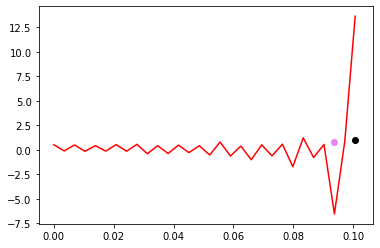

[13.639534883720929, -6.552731330831548, 0.28272494955780453, 7.690334751329993]


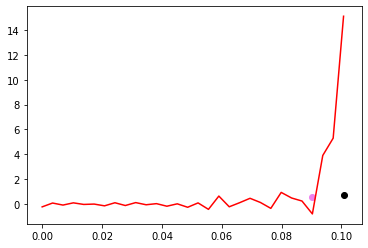

[15.10377358490566, -0.7903097782357722, 0.8092019572152174, 8.202209957916388]


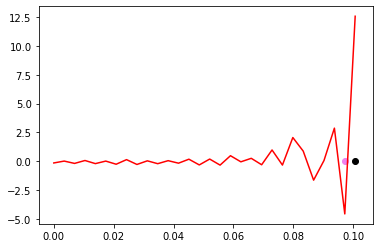

[12.555555555555552, -4.549071616140221, 0.38940693742973864, 6.1817840699060485]


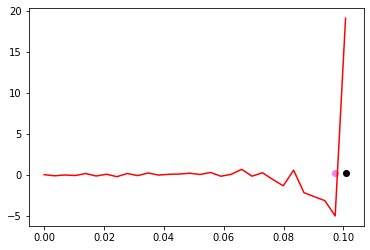

[19.088235294117652, -4.987069732554668, 0.20965807933263342, 13.311635631750686]


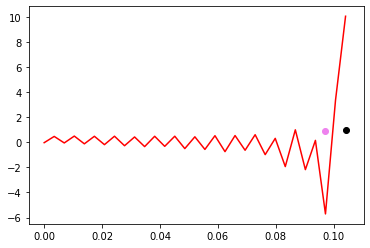

[10.088888888888889, -5.712856683267215, 0.19684984294871988, 5.155300318542535]


[[14.152941176470591,
  -7.79180485872869,
  0.1829278452159737,
  8.896929188242058],
 [20.2, -5.705957551777416, 0.2628243748125339, 14.552350844796294],
 [14.357615894039736,
  -8.252658531102163,
  0.1310711632757856,
  9.062951244246785],
 [13.521126760563382,
  -7.737259637951441,
  0.1929759859978857,
  8.274060830032717],
 [15.063829787234036,
  -5.980068671572691,
  0.1861416483262577,
  9.299395300251561],
 [15.985611510791369,
  -8.253866169424075,
  0.20302508965366958,
  10.734341752012881],
 [14.719101123595504,
  -7.833855632170877,
  0.1589898491539232,
  9.265724911626203],
 [13.546762589928058,
  -8.04421424055926,
  0.1735090552018789,
  8.556563634110683],
 [15.839080459770118,
  -7.581522380154777,
  0.23032631324794225,
  10.372258455077953],
 [12.030303030303031,
  -6.473668542026381,
  0.1576539300092298,
  6.510343259621045],
 [18.029850746268657,
  -8.12147926407745,
  0.34633296697722915,
  12.673942121347247],
 [13.251497005988021,
  -7.866720978916915,
  0.

In [114]:
Feature_vector=[]
for i in range(0, len(cgmSeries_np)):
#FFT
    fastfouriertransform=rfft(cgmNorm_np[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], fastfouriertransform, c='red')
    fft_max=np.nanmax(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_max)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='black')
    fft_min=np.nanmin(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_min)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='violet')
    fft_mean=np.nanmean(fastfouriertransform)
    fft_variance=np.nanvar(fastfouriertransform)
    Feature_vector.append([fft_max,fft_min,fft_mean,fft_variance])
    plt.show()
    print([fft_max,fft_min,fft_mean,fft_variance])
display(Feature_vector)   

# 2. Generating Feature Matrix, Visualizing Spread and PCA

In [118]:
# Feature Matrix
matrix = []
for i in range(0, len(cgmSeries_np)):
    matrix_row = np.array([])
    # Anirudh
    matrix_row = np.append(matrix_row, slopes[i])
    matrix_row = np.append(matrix_row, time_diffs[i])
    matrix_row = np.append(matrix_row, peak_values[i])
    matrix_row = np.append(matrix_row, peak_heights[i])
    matrix_row = np.append(matrix_row, peak_times[i])
    # Vedant
    matrix_row = np.append(matrix_row, window_mins[i])
    matrix_row = np.append(matrix_row, window_maxs[i])
    matrix_row = np.append(matrix_row, window_vars[i])
    matrix_row = np.append(matrix_row, window_means[i])
    # Omkar
    matrix_row = np.append(matrix_row, mean_before[i])
    matrix_row = np.append(matrix_row, mean_after[i])
    matrix_row = np.append(matrix_row, mean_dif[i])
    # Ananth
    matrix_row = np.append(matrix_row, Feature_vector[i])
    if len(matrix) == 0:
        matrix = np.array([matrix_row])
    else:
        matrix = np.append(matrix, [matrix_row], axis=0)
       
matrix = np.nan_to_num(matrix)
# Normalizing Values
transformer = pre.FunctionTransformer(np.log1p, validate=True)
matrix = transformer.transform(matrix)
matrix = np.nan_to_num(matrix)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:179: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [119]:
# Converting to dataframe for easy visualization
columns = ['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ]
feature_df = pd.DataFrame(matrix, columns=columns)
display(feature_df)

,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Var2_window,Mean1_window,Mean2_window,Mean_before,Mean_after,Mean_diff,Max_fft,Min_fft,Mean_fft,Var_fft
0,2.527327,0.083243,0.594301,0.421030,0.034686,0.094240,0.070381,0.054067,0.126892,0.216060,...,0.021643,0.286505,0.355616,0.005865,0.436672,0.432864,2.718195,0.000000,0.167993,2.292225
1,3.071370,0.047467,0.670674,0.587787,0.091938,0.145862,0.060625,0.030772,0.000000,0.407931,...,0.023738,0.192150,0.525824,0.501752,0.000000,0.000000,3.054001,0.000000,0.233351,2.744212
2,2.688819,0.070381,0.683164,0.300840,0.117341,0.156607,0.073612,0.044150,0.106684,0.164504,...,0.039809,0.298877,0.380883,0.037372,0.549367,0.527138,2.731612,0.000000,0.123165,2.308860
3,2.645530,0.073612,0.214657,0.520636,0.111819,0.150118,0.047467,0.060625,0.087598,0.041385,...,0.037213,0.308934,0.225956,0.029832,0.477458,0.458494,2.675605,0.000000,0.176451,2.227221
4,3.496508,0.030772,0.580669,0.580669,0.164432,0.264000,0.070381,0.040822,0.021053,0.157186,...,0.058679,0.289807,0.398348,0.131688,0.563720,0.480228,2.776570,0.000000,0.170706,2.332085
5,2.782409,0.063887,0.537797,0.663948,0.119221,0.130650,0.054067,0.067139,0.128121,0.069472,...,0.033774,0.333384,0.251794,0.022359,0.500007,0.486198,2.832367,0.000000,0.184839,2.462520
6,3.496508,0.030772,0.658858,0.323548,0.187924,0.330031,0.063898,0.044161,0.000000,0.000000,...,0.071936,0.298855,0.197192,0.072234,0.490721,0.443780,2.754877,0.000000,0.147549,2.328811
7,2.688819,0.070381,0.201325,0.525112,0.070814,0.082806,0.044150,0.060625,0.108951,0.049133,...,0.026734,0.289120,0.213021,0.016647,0.464335,0.453728,2.677368,0.000000,0.159998,2.257228
8,2.456736,0.089612,0.557972,0.386122,0.121098,0.141260,0.057351,0.047467,0.188052,0.159065,...,0.030550,0.371960,0.299679,0.032512,0.508315,0.488237,2.823702,0.000000,0.207279,2.431177
9,3.005049,0.050805,0.685543,0.537733,0.231593,0.264619,0.050805,0.040822,0.310155,0.252997,...,0.051127,0.503526,0.425466,0.015038,0.400825,0.390625,2.567278,0.000000,0.146395,2.016281


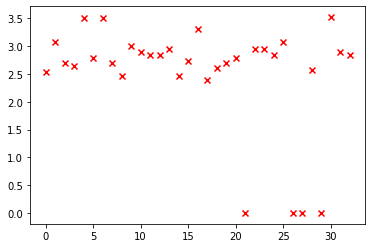

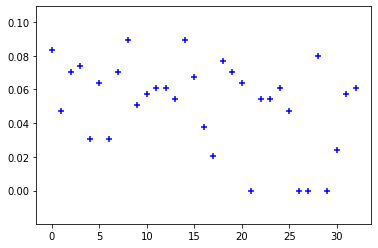

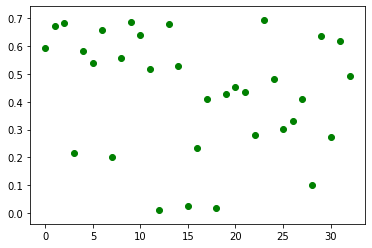

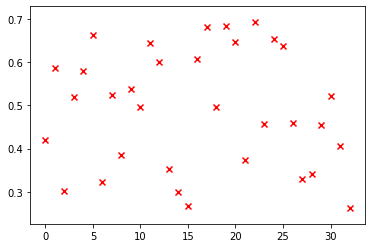

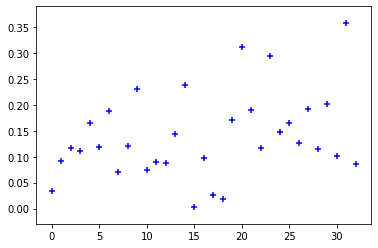

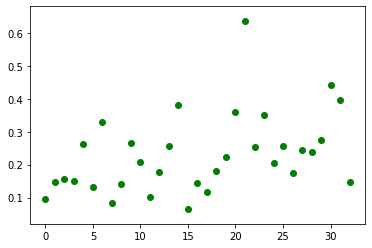

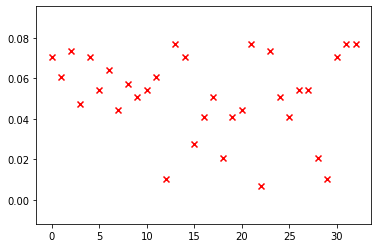

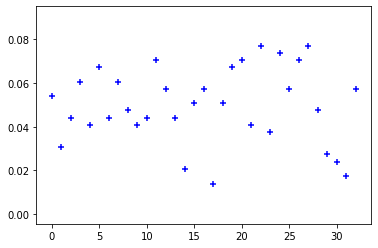

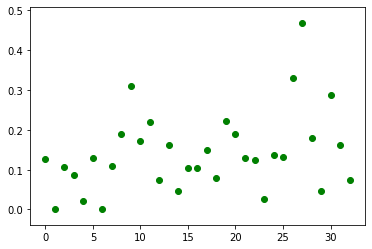

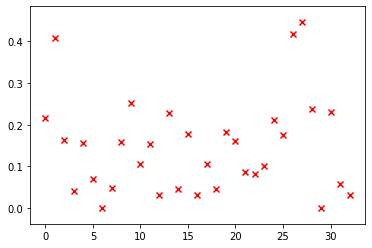

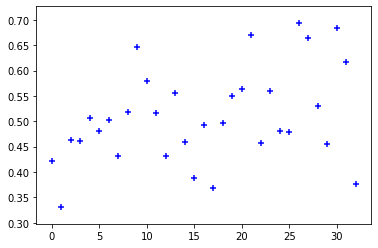

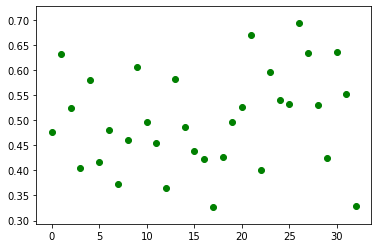

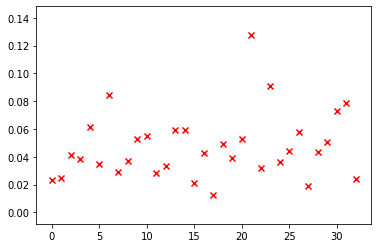

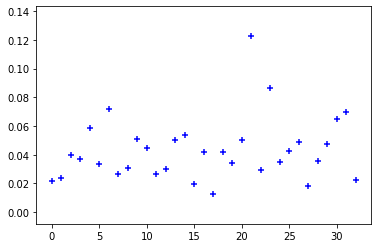

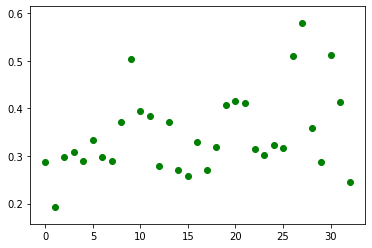

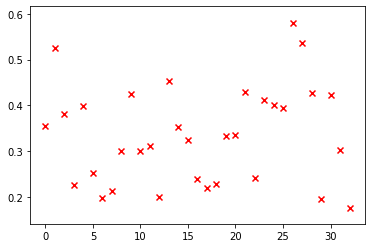

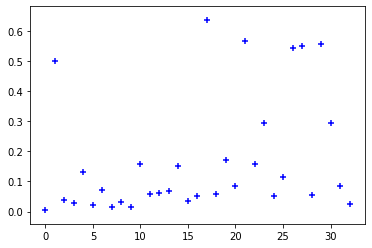

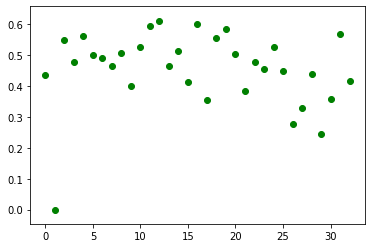

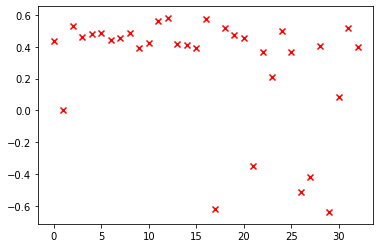

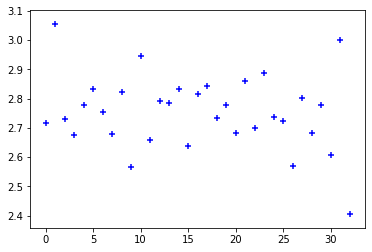

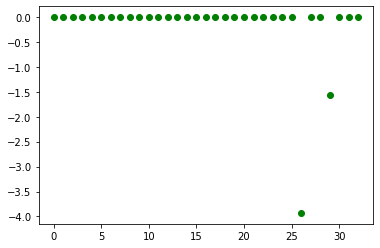

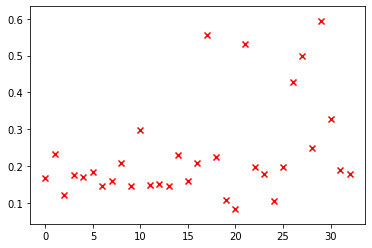

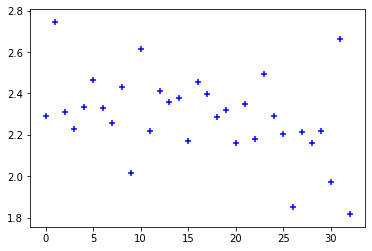

In [120]:
# Scatter Visualization
rows = [i for i in range(len(cgmNorm_np))]
colors = ['red', 'blue', 'green']
markers = ['x', '+', 'o']
for i in range(0, matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
    plt.show()

1.3674305386319552


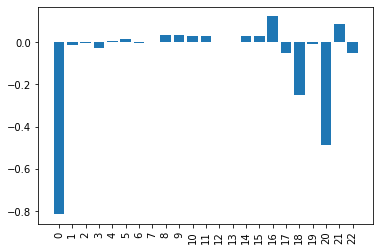

[-0.81497042 -0.01422158 -0.00155894 -0.0250788   0.00635415  0.01710659
 -0.00176617  0.00115796  0.03312942  0.03244816  0.02909836  0.02719363
  0.00281178  0.00265649  0.02820199  0.03125543  0.12200017 -0.05026192
 -0.25144902 -0.00707334 -0.48781518  0.08849414 -0.05144361]
0.2806646958066178


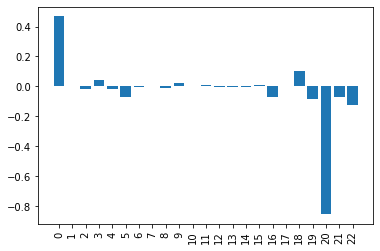

[ 0.46695503  0.00223994 -0.02050584  0.04559336 -0.01561511 -0.06888745
 -0.00259174  0.0037219  -0.00768581  0.02409902  0.00279538  0.00731637
 -0.00294026 -0.0046589  -0.00314048  0.01215886 -0.07342165  0.00322718
  0.10341021 -0.08593183 -0.85420601 -0.07424061 -0.12202847]
0.08588859020980229


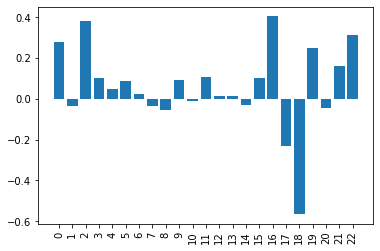

[ 0.27597931 -0.03674492  0.38119949  0.10265458  0.0475746   0.08611501
  0.02272956 -0.03522085 -0.05378916  0.09111966 -0.01354528  0.10753126
  0.01365371  0.01322014 -0.03211084  0.10084814  0.40258284 -0.22895799
 -0.56509026  0.24736431 -0.04299984  0.15882856  0.31401667]
0.05593991261601014


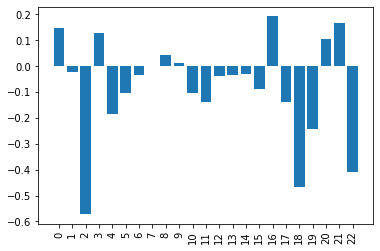

[ 0.14746242 -0.02312297 -0.57194162  0.1268112  -0.18717479 -0.10529982
 -0.03692622  0.0015628   0.04174281  0.01006025 -0.10584051 -0.1401828
 -0.03890632 -0.03478434 -0.03276471 -0.09016559  0.19072564 -0.13982429
 -0.46863266 -0.24503428  0.10561697  0.16687965 -0.40965849]
0.04415041911764708


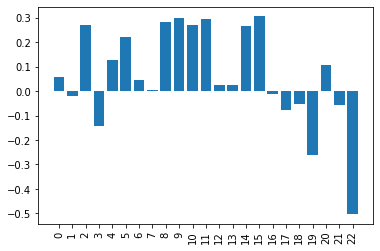

[ 0.05700386 -0.01997276  0.27138528 -0.14280006  0.1285242   0.21983071
  0.04351908  0.00576224  0.28309397  0.2965894   0.26855312  0.29220898
  0.02630166  0.02472113  0.26546775  0.30429939 -0.01257793 -0.07690418
 -0.05391093 -0.26303918  0.10659353 -0.05660169 -0.50280793]


In [121]:
# PCA
pca = PCA()
pca.fit(matrix)
components = pca.components_
variances = pca.explained_variance_
x = [i for i in range(0, len(components[0]))]
for i in range(0, 5):
    print(variances[i])
    plt.figure()
    plt.bar(x, components[i])
    plt.xticks(np.arange(len(components[0])), x, rotation=90)
    plt.show()
    print(components[i])